In [1]:
# Import liberaries and functions
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', autolayout=True)

import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)

In [2]:
# Load data sample 
RF_df = pd.read_csv("Data\clean_docs_3.csv")

In [3]:
# Load Top2Vec topics df
t2v_df = (
    pd.read_csv("Top2Vec\T2V_df_H95.csv")
    .set_index("index").drop(columns=['Docs'])
)

In [4]:
topics_df = pd.concat([RF_df, t2v_df[['Topic', 'Score', 'Topic_H', 'Score_H']]], axis=1)

topics_df["filing_dt"] = pd.to_datetime(topics_df["filing_dt"])
topics_df["report_dt"] = pd.to_datetime(topics_df["report_dt"])

topics_df['rprt_length'] = topics_df['cleaned_txt'].map(lambda x: len(x.split()))

In [5]:
# Use historical SIC data for industry analysis
sich = pd.read_csv(
    filepath_or_buffer="Data\Financials.csv",
    decimal=".", 
    thousands=',',
    usecols=[
        'cik', 'datadate', 'sich'
    ]
).drop_duplicates()

sich.sort_values(['cik', 'datadate'], inplace=True)
sich["datadate"] = pd.to_datetime(sich["datadate"], format="%d/%m/%Y")

topics_df = pd.merge(
    left=topics_df,
    right=sich[[
        'cik', 'datadate', 'sich']],
    left_on=["CIK", "report_dt"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate', 'cik'])

topics_df['sich'] = topics_df['sich'].fillna(topics_df['SIC']).astype(int)

In [6]:
with open("Top2Vec\\topic_hierarchy.txt", 'rb') as f:
    TH = pickle.load(f)

df = pd.DataFrame(TH).reset_index()

TH = (
    pd.melt(df, id_vars=['index'])
    .dropna()
    .astype(int)
    .sort_values(['index', 'value'])
    .drop(columns='variable')
)

In [7]:
topics_df['Topic_H'] = pd.merge(
    left=topics_df,
    right=TH[['index', 'value']],
    left_on=['Topic'],
    right_on=['value'],
    how='left'
)['index']

### Firm level

In [8]:
group = 'CIK'

In [9]:
# Risk topics disclosed and not disclosed per report 
disc_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt", "sich"], 
    columns='Topic', values='Score'
).notna().astype(int).reset_index()

In [10]:
disc_long = pd.melt(disc_df, id_vars=["CIK", "filing_dt", "report_dt", "sich"])
disc_long.sort_values([group, 'Topic', 'filing_dt'], inplace=True)

disc_long['Occurence'] = disc_long.groupby([group, 'Topic'])['value'].cumsum()

In [11]:
disc_long['min_occ'] = disc_long.groupby([group, 'Topic'])['Occurence'].transform('min')
disc_long['max_occ'] = disc_long.groupby([group, 'Topic'])['Occurence'].transform('max')

# Keep risk topics that are not always present in a firm and are disclosed at list once
# Keep observations that the RF is disclosed
disc_long = disc_long[
    (disc_long['min_occ']==0)&
    (disc_long['max_occ']>0)&
    (disc_long['value']>0)
]

In [12]:
count_rpt = disc_long.groupby(group)['filing_dt'].transform('nunique')
disc_long = disc_long[count_rpt>1]

### Industry level

In [39]:
group = 'sich'

In [40]:
# Counting the actual number of firms per industry
filings_df = pd.read_csv("Data\\filings_df.csv")

filings_df.dropna(subset=["filingDate", "reportDate", "sic"], inplace=True)

filings_df["filingDate"] = pd.to_datetime(filings_df["filingDate"])
filings_df["reportDate"] = pd.to_datetime(filings_df["reportDate"])

filings_df = filings_df.sort_values(['cik', 'reportDate', 'filingDate']).drop_duplicates(keep='last')

In [41]:
# Historical SIC
filings_df = pd.merge(
    left=filings_df,
    right=sich[[
        'cik', 'datadate', 'sich']],
    left_on=["cik", "reportDate"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate'])

filings_df['sich'] = topics_df['sich'].fillna(filings_df['sic']).astype(int)

In [42]:
# Risk topics disclosed and not disclosed per report 
disc_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt", group], 
    columns='Topic_H', values='Score_H'
).notna().astype(int).reset_index()

In [43]:
filings_df = filings_df[
    (filings_df["filingDate"] >= disc_df['filing_dt'].min())
    &(filings_df["filingDate"] <= disc_df['filing_dt'].max())
]
filings_df['fyear'] = filings_df["filingDate"].dt.year
filings_df['sic3'] = filings_df["sich"].map(lambda x: f"{int(x):04d}"[:3])

# Number of reporting firms per filing year
filings_df['#firms'] = filings_df.groupby('sic3')['filingDate'].transform('nunique')

In [44]:
disc_long = pd.melt(disc_df, id_vars=["CIK", "filing_dt", "report_dt", group])

disc_long[f"{group}3"] = disc_long[group].map(lambda x: f"{int(x):04d}"[:3])

disc_long.sort_values([f"{group}3", 'Topic_H', 'filing_dt'], inplace=True)

In [45]:
disc_long = pd.merge(
    left=disc_long,
    right=filings_df[['filingDate', 'reportDate', 'cik', '#firms']],
    left_on=['CIK', 'report_dt'],
    right_on=['cik', 'reportDate'],
    how='left'
).dropna(subset=['cik', 'reportDate']).drop(columns=['filingDate', 'reportDate', 'cik'])

In [46]:
disc_long['Occurence'] = disc_long.groupby([f"{group}3", 'Topic_H'])['value'].cumsum()

# disc_long['#firms'] = disc_long.groupby(f"{group}3")['filing_dt'].transform('nunique')

disc_long['frac'] = disc_long['Occurence'] / disc_long['#firms']

In [47]:
disc_long['min_frac'] = disc_long.groupby([group, 'Topic_H'])['frac'].transform('min')
disc_long['max_frac'] = disc_long.groupby([group, 'Topic_H'])['frac'].transform('max')

In [11]:
disc_long = disc_long[
    (disc_long['min_frac']<=0.1)
    &(disc_long['max_frac']>=0.2)
    &(disc_long['value']>0)
]

In [127]:
# Start from one year after the earliest filing date
disc_df["filing_dt-1"] = disc_df["filing_dt"] - pd.Timedelta(weeks=52)
disc_df = disc_df[disc_df["filing_dt"]>'2007-02-01']
disc_df['sich'] = disc_df['sich'].map(lambda x: f"{int(x):04d}"[:2])

In [129]:
count_rpt = disc_df.groupby(group)['filing_dt'].transform('nunique')
disc_df = disc_df[count_rpt>2]

In [130]:
def count_func(x):
    df_slice = disc_df[
        (disc_df["filing_dt"]>x["filing_dt-1"])&
        (disc_df["filing_dt"]<=x["filing_dt"])&
        (disc_df['sich']==x['sich'])
    ]
    output = (
        df_slice.filter(range(0,100)).sum() / 
        df_slice["CIK"].count()
    )
    
    return output

In [131]:
disc_df.loc[:, range(0,95)] = disc_df.apply(count_func, axis=1)
disc_df.drop(columns=['filing_dt-1'], inplace=True)

## Daily data

In [13]:
prices_df = pd.read_csv("Data\Prices.csv")
prices_df["Date"] = pd.to_datetime(prices_df["Date"])
prices_df.sort_values(["Instrument", "Date"], inplace=True)
prices_df = prices_df[prices_df["Date"]>'2005-01-01'].set_index('Date')
prices_df.columns

Index(['Instrument', 'CLOSEPRICE', 'VOLUME', 'COMPANYMARKETCAP',
       'TTLCMNSHARESOUT'],
      dtype='object')

In [14]:
# Daily shares turnover
prices_df["SHRTURN"] = prices_df["VOLUME"] / prices_df["TTLCMNSHARESOUT"]

# Returns
prices_df["Return"] = prices_df.groupby("Instrument")["CLOSEPRICE"].pct_change(1)

In [15]:
# Time window
N = 20

# Average of N-day std of daily returns
std_returns = (
    prices_df.groupby("Instrument")["Return"]
    .rolling(N, min_periods=N//2).std().to_frame()
)
std_returns[f"stdReturn+{N}"] = std_returns.groupby("Instrument")["Return"].shift(-N-2)
std_returns[f"stdReturn_{N}"] = std_returns.groupby("Instrument")["Return"].shift(2)

In [16]:
# Average of N-day trade volumes
N=5
MA_vol = prices_df.groupby("Instrument")["VOLUME"].rolling(N, min_periods=3).mean().to_frame()
MA_vol[f"VOLUME"] = MA_vol.groupby("Instrument")["VOLUME"].shift(N//2)
MA_vol["SHRTURN"] = prices_df.groupby("Instrument")["SHRTURN"].rolling(N, min_periods=3).mean()
MA_vol[f"SHRTURN"] = MA_vol.groupby("Instrument")["SHRTURN"].shift(N//2)

In [17]:
# Time window
N = 30

# Average of 60-day std of daily returns
std_returns[f"stdReturn+{N}"] = prices_df.groupby("Instrument")["Return"].rolling(N, min_periods=N//2).std().groupby("Instrument").shift(-N-2)
std_returns[f"stdReturn_{N}"] = prices_df.groupby("Instrument")["Return"].rolling(N, min_periods=N//2).std().groupby("Instrument").shift(2)

In [18]:
for N in [20, 30]:
    std_returns[f"D_std{N}"] = (std_returns[f"stdReturn+{N}"] - std_returns[f"stdReturn_{N}"])/std_returns[f"stdReturn_{N}"]

In [19]:
BidAsk_df = pd.read_csv("Data\BidAsk.csv").drop_duplicates()
BidAsk_df["Date"] = pd.to_datetime(BidAsk_df["Date"])
BidAsk_df.set_index('Date', inplace=True)
BidAsk_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8687523 entries, 2006-01-17 to 2022-06-14
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Instrument  int64  
 1   HIGHPRICE   float64
 2   LOWPRICE    float64
 3   BIDPRICE    float64
 4   ASKPRICE    float64
dtypes: float64(4), int64(1)
memory usage: 397.7 MB


In [20]:
BidAsk_df["BAspread"] = (BidAsk_df["ASKPRICE"] - BidAsk_df['BIDPRICE'])/BidAsk_df["ASKPRICE"]

In [21]:
N = 20

# N-day moving average (trading days only)
MA_BA = BidAsk_df.groupby('Instrument')['BAspread'].rolling(N, min_periods=N//2).mean().to_frame()
MA_BA[f"avgBA+{N}"] = MA_BA.groupby("Instrument")["BAspread"].shift(-N-2)
MA_BA[f"avgBA_{N}"] = MA_BA.groupby("Instrument")["BAspread"].shift(2)

MA_BA.drop(columns='BAspread', inplace=True)

In [22]:
N = 30
# N-day moving average (trading days only)
MA_BA[f"avgBA+{N}"] = BidAsk_df.groupby('Instrument')['BAspread'].rolling(N, min_periods=N//2).mean().groupby("Instrument").shift(-N-2)
MA_BA[f"avgBA_{N}"] = BidAsk_df.groupby('Instrument')['BAspread'].rolling(N, min_periods=N//2).mean().groupby("Instrument").shift(2)

In [23]:
for N in [20, 30]:
    MA_BA[f"D_ba{N}"] = (MA_BA[f"avgBA+{N}"] - MA_BA[f"avgBA_{N}"])/MA_BA[f"avgBA_{N}"]

In [24]:
Beta = pd.read_csv("Data\Beta_AR.csv")
Beta.drop_duplicates(inplace=True)
Beta.columns

Index(['Date', 'Instrument', 'Beta_30', 'Beta_90', 'Beta_250', 'AR', 'CAR_10',
       'CAR_20', 'CAR_30'],
      dtype='object')

In [25]:
Beta['Date'] = pd.to_datetime(Beta['Date'])
Beta.set_index('Date', inplace=True)

In [26]:
# Daily Beta
Beta["BETA+90"] = Beta.groupby('Instrument')["Beta_90"].shift(-90-2)
Beta["BETA_90"] = Beta.groupby('Instrument')["Beta_90"].shift(2)

In [27]:
Analysts = pd.read_csv("Data\Analysts.csv")
Analysts.dropna(inplace=True)

Analysts.columns = ['Instrument', 'NUMBEROFANALYSTS', 'Date']
Analysts['Date'] = pd.to_datetime(Analysts['Date'], errors='coerce').dt.tz_localize(None)

In [28]:
Analyst_df = pd.merge(
    left=prices_df["Instrument"], 
    right=Analysts, 
    on=["Date", "Instrument"],
    how="outer"
)

Analyst_df = Analyst_df[(Analyst_df["Date"]>'2005-01-01')&(Analyst_df["Date"]<'2023-01-01')]

Analyst_df.sort_values(['Instrument', 'Date', 'NUMBEROFANALYSTS'], inplace=True)

In [29]:
Analyst_df["NUMBEROFANALYSTS"] = Analyst_df.groupby("Instrument")["NUMBEROFANALYSTS"].fillna(method='ffill')
Analyst_df.drop_duplicates(subset=['Instrument', 'Date'], keep='last', inplace=True)
Analyst_df.fillna(0, inplace=True)

In [30]:
# Load annual financial data
# Fill NAs with last (previouse) observation and drop duplicates
financials = pd.read_csv(
    filepath_or_buffer="Data\Financials.csv",
    decimal=".", 
    thousands=',',
).drop_duplicates()

financials.sort_values(['cik', 'datadate'], inplace=True)

In [31]:
financials["datadate"] = pd.to_datetime(financials["datadate"], format="%d/%m/%Y")
financials["seq"].fillna(financials["teq"], inplace=True)

In [32]:
# Leverage
financials["DtA"] = financials["dt"] / financials["at"].replace(0, np.nan)
financials["DtEBITDA"] = financials["dt"] / financials["ebitda"].replace(0, np.nan)

# Profitability
financials["ROE"] = financials["ni"] / financials["seq"].replace(0, np.nan)
financials["NPM"] = financials["ni"] / financials["revt"].replace(0, np.nan) # net profit margin

# Firm size
financials["logMC"] = np.log(financials["mkvalt"].replace(0, np.nan))
financials["logTA"] = np.log(financials["at"].replace(0, np.nan))

# Intangible assets
financials["RtINT"] = financials["revt"] / financials["intan"].replace(0, np.nan)
financials["INTtA"] = financials["intan"] / financials["at"].replace(0, np.nan) 

# Liquidity
financials["current"] = financials["act"] / financials["lct"].replace(0, np.nan)

# Other
financials["TobinQ"] = financials["mkvalt"] / financials["at"].replace(0, np.nan)
financials["BtM"] = financials["seq"] / financials["mkvalt"].replace(0, np.nan)

# R&D intensity
financials["RDxopr"] = financials["xrd"].fillna(0) / financials["xopr"].replace(0, np.nan)
financials["ProprietaryCost"] = financials["xrd"].fillna(0) / financials.groupby('cik')["at"].shift(1).replace(0, np.nan)

# %change in earnings
financials["DEarnings"] = financials.groupby("cik")["ni"].pct_change(1).replace(np.Inf, np.nan)
financials["DEarnings"].replace(-np.Inf, np.nan, inplace=True)

In [33]:
financials.columns

Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'curcd', 'act', 'at', 'dt', 'ebit', 'ebitda', 'intan', 'lct', 'lt',
       'ni', 'revt', 'seq', 'teq', 'xopr', 'xrd', 'xt', 'cik', 'costat',
       'naicsh', 'sich', 'mkvalt', 'naics', 'sic', 'DtA', 'DtEBITDA', 'ROE',
       'NPM', 'logMC', 'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM',
       'RDxopr', 'ProprietaryCost', 'DEarnings'],
      dtype='object')

## Merge data

In [34]:
rprt_length = (
    topics_df.groupby(["CIK", "report_dt", "filing_dt"])['rprt_length'].sum()
).reset_index().drop_duplicates(subset=["CIK", "filing_dt", "report_dt"])

disc_long = pd.merge(
    left=disc_long, 
    right=rprt_length,
    on=["CIK", "filing_dt", "report_dt"],
    how='left'
)

In [35]:
disc_long = pd.merge(
    left=disc_long,
    right=std_returns,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

disc_long = pd.merge(
    left=disc_long,
    right=MA_BA,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

disc_long = pd.merge(
    left=disc_long,
    right=MA_vol,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

In [36]:
disc_long = pd.merge(
    left=disc_long,
    right=Beta.reset_index()[[
        'Instrument', 'Date', 'BETA_90',
        'CAR_10', 'CAR_20', 'CAR_30'
    ]],
    left_on=["CIK", "filing_dt"],
    right_on=['Instrument', 'Date'],
    how="left"
).drop(columns=['Instrument', 'Date'])

disc_long = pd.merge(
    left=disc_long,
    right=Analyst_df[['Date', 'Instrument', 'NUMBEROFANALYSTS']],
    left_on=["CIK", "filing_dt"],
    right_on=['Instrument', 'Date'],
    how="left"
).drop(columns=['Instrument', 'Date'])

disc_long = pd.merge(
    left=disc_long,
    right=financials[[
        'cik', 'datadate', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'logMC', 'logTA', 'RtINT', 
        'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr', 'ProprietaryCost', 'DEarnings'
    ]],
    left_on=["CIK", "report_dt"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate', 'cik'])

In [37]:
# disc_long.dropna(inplace=True)
disc_long['rfGap'] = (disc_long['filing_dt'] - disc_long['report_dt']).dt.days
disc_long['fyear'] = disc_long['filing_dt'].dt.year
disc_long['ryear'] = disc_long['report_dt'].dt.year

In [38]:
disc_long.to_csv('Data\study1_more(3).csv', index=False)

Table of mean per OCC

In [77]:
firm = pd.read_csv('Data\study1_more(3).csv')
# industry = pd.read_csv('Data\study1_more(2)(2).csv')

In [78]:
firm["filing_dt"] = pd.to_datetime(firm["filing_dt"])
firm["report_dt"] = pd.to_datetime(firm["report_dt"])

In [79]:
firm = pd.merge(
    left=firm,
    right=TH[['index', 'value']],
    left_on=['Topic'],
    right_on=['value'],
    how='left'
).rename(columns={'index': 'Topic_H'})

In [87]:
df = pd.merge(
    left=firm,
    right=disc_long[['CIK', 'filing_dt', 'report_dt', 'Topic_H', 'frac', '#firms']],
    on = ['CIK', 'filing_dt', 'report_dt', 'Topic_H'],
    how='left'
)

In [88]:
df.to_csv('Data\study1_more.csv', index=False)

In [117]:
firm.dropna(inplace=True)

In [102]:
firm.dropna(subset=['stdReturn+20', 'D_std20', 'CAR_20', 'avgBA+20', 'D_ba20'], inplace=True)
industry.dropna(subset=['stdReturn+20', 'D_std20', 'CAR_20', 'avgBA+20', 'D_ba20'], inplace=True)

In [118]:
winsor = ['stdReturn+20', 'D_std20', 'CAR_20', 'avgBA+20', 'D_ba20']
df1 = firm[(firm['Occurence']<=10)].copy()
df1[winsor] = df1[winsor].clip(
    lower=df1[winsor].quantile(0.01), 
    upper=df1[winsor].quantile(0.99), 
    axis=1
)*100

df2 = industry.copy()
df2[winsor] = df2[winsor].clip(
    lower=df2[winsor].quantile(0.01), 
    upper=df2[winsor].quantile(0.99), 
    axis=1
)*100

In [119]:
Occ_df1 = df1.groupby('Occurence')[winsor].mean()
Occ_df1['Obs'] = df1.groupby("Occurence")['Topic'].count()

In [106]:
bins = np.arange(0, 1.1, 0.1)
labels = range(1, 11)
df2['frac_bin'] = pd.cut(df2['frac'], bins=bins, labels=labels)

In [107]:
Occ_df2 = df2.groupby('frac_bin')[winsor].mean()
Occ_df2['Obs'] = df2.groupby("frac_bin")['Topic_H'].count()

Create OCC graphs

In [96]:
# graph = disc_long[(disc_long['filing_dt']>'2011-01-01')&(disc_long['filing_dt']<'2016-01-01')].copy()
graph_1 = industry[industry['Occurence']<=5]

In [4]:
graph_2 = firm[firm['Occurence']<=5]

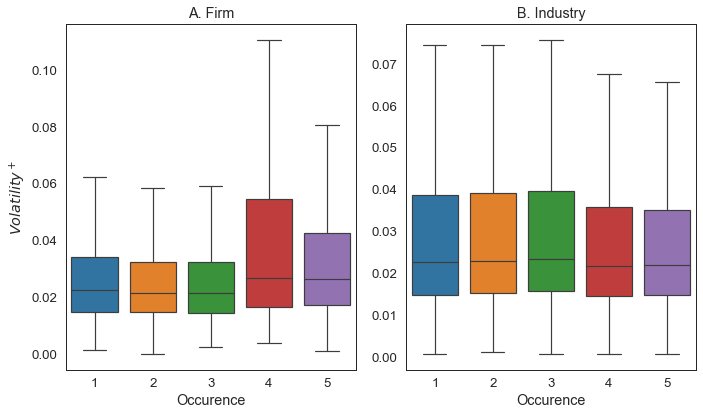

In [97]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
fig.tight_layout()

sns.boxplot(
    data=firm, x = 'Occurence', y = 'stdReturn+20', showfliers=False, ax=ax[0]
)
sns.boxplot(
    data=graph_1, x = 'Occurence', y = 'stdReturn+20', showfliers=False, ax=ax[1]
)

ax[0].set_xlabel('Occurence')
ax[1].set_xlabel('Occurence')
ax[0].set_ylabel("$Volatility^+$")
ax[1].set_ylabel("")
ax[0].set_title('A. Firm')
ax[1].set_title('B. Industry')
plt.savefig('occurence.png', dpi=300)
plt.show()

In [75]:
covid = disc_long[(disc_long['Topic_H']==94)&(disc_long['filing_dt']>'2019-06-01')&(disc_long['Occurence']<=3)&((disc_long['value']>=1))]

Summary tables

In [2]:
stat_data = pd.read_csv('Data\stats_data_T2V_H_V3.csv')

In [3]:
stat_data.dropna(
    subset=['added', 'stdReturn+20', 'stdReturn_20', 'SHRTURN', 'NUMBEROFANALYSTS', 'DtA', 
            'NPM', 'INTtA', 'current', 'BtM', 'DEarnings', 'BETA_90'],
    inplace=True
)

In [47]:
year = stat_data.groupby('fyear')[["reported_crnt", "added", "repeated"]].mean()#.agg(['mean', 'std'])
ind = stat_data.groupby('Industry')[["reported_crnt", "added", "repeated"]].agg(['mean', 'std'])

year['obs'] = stat_data.groupby('fyear')['CIK'].count()
# year['firms'] = stat_data.groupby('fyear')['CIK'].nunique()

year.loc['Total', [('reported_crnt', 'mean'), ('added', 'mean'), ('repeated', 'mean')]] = (
    stat_data[["reported_crnt", "added", "repeated"]].mean().values
)
year.loc['Total', [('reported_crnt', 'std'), ('added', 'std'), ('repeated', 'std')]] = (
    stat_data[["reported_crnt", "added", "repeated"]].std().values
)
year.loc['Total', 'obs'] = year['obs'].sum()

In [9]:
stat_data['D_std'] = (stat_data['stdReturn+20'] - stat_data['stdReturn_20'])*100 / stat_data['stdReturn_20']
stat_data['D_ba'] = (stat_data['avgBA+20'] - stat_data['avgBA_20'])*100 / stat_data['avgBA_20']
stat_data[['stdReturn+20', 'CAR_20', 'avgBA+20']] = stat_data[['stdReturn+20', 'CAR_20', 'avgBA+20']] * 100

In [10]:
year = stat_data.groupby('fyear')[["reported_crnt", "added", "repeated", 'stdReturn+20', 'D_std', 'CAR_20', 'avgBA+20', 'D_ba', 'BETA_90']].mean()

In [48]:
year[[(          'obs',     ''),
    ('reported_crnt', 'mean'),
    ('reported_crnt',  'std'),
    (        'added', 'mean'),
    (        'added',  'std'),
    (     'repeated', 'mean'),
    (     'repeated',  'std'),
]].round(0).astype(int).to_latex('disc_year.tex')

In [49]:
df = topics_df[topics_df['CIK'].isin(stat_data['CIK'])].copy()
df['ryear'] = df['report_dt'].dt.year

sum_year = pd.DataFrame()
sum_year['#CIK'] = df.groupby('ryear')['CIK'].nunique()
sum_year['#RF'] = df.groupby(['ryear', 'CIK'])['rf_seq'].count().reset_index().groupby('ryear')['rf_seq'].mean().round()
sum_year['#IT'] = df.groupby(['ryear', 'CIK'])['Topic'].nunique().reset_index().groupby('ryear')['Topic'].mean().round()
sum_year['#TC'] = df.groupby(['ryear', 'CIK'])['Topic_H'].nunique().reset_index().groupby('ryear')['Topic_H'].mean().round()

sum_ind = pd.DataFrame()
sum_ind['#CIK'] = df.groupby('Industry')['CIK'].nunique()
sum_ind['#RF'] = df.groupby(['Industry', 'ryear', 'CIK'])['rf_seq'].count().reset_index().groupby('Industry')['rf_seq'].mean().round()
sum_ind['#IT'] = df.groupby(['Industry', 'ryear', 'CIK'])['Topic'].nunique().reset_index().groupby('Industry')['Topic'].mean().round()
sum_ind['#TC'] = df.groupby(['Industry', 'ryear', 'CIK'])['Topic_H'].nunique().reset_index().groupby('Industry')['Topic_H'].mean().round()

sum_ind.astype(int).to_latex('ind_tbl.tex')
sum_year.astype(int).to_latex('yr_tbl.tex')

In [50]:
topics_df['ryear'] = topics_df['report_dt'].dt.year

df = topics_df.groupby("ryear")[['Topic', 'Topic_H']].agg({'Topic': lambda l: set(l), 'Topic_H': lambda l: set(l)}).reset_index()
df["shifted"] = df['Topic'].shift(1)

df.dropna(inplace=True)

df["repeated"] = df.apply(lambda r: r['Topic'].intersection(r['shifted']), axis=1)
df["added"] = df.apply(lambda r: r['Topic'].difference(r['shifted']), axis=1)
df["removed"] = df.apply(lambda r: r['shifted'].difference(r['Topic']), axis=1)
df["reported_crnt"] = df['Topic'].map(len)
df["repeated"] = df["repeated"].map(len)
df["added"] = df["added"].map(len)
df["removed"] = df["removed"].map(len)

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
plt.rc('figure', autolayout=True)

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})
%config InlineBackend.figure_format = 'retina'

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(year[('reported_crnt', 'mean')])
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Reported risk topics')

# plt.savefig("HReduction.png", dpi=600)
plt.show()